Using device: cpu
Files already downloaded and verified
Training process for WGAN:
╒═════════╤══════════════════╤═══════════════╤═════════════╕
│   Epoch │   Generator Loss │   Critic Loss │   FID Score │
╞═════════╪══════════════════╪═══════════════╪═════════════╡
│       1 │           0.2572 │       -0.2676 │     594.848 │
├─────────┼──────────────────┼───────────────┼─────────────┤
│       2 │           0.2845 │       -0.3556 │     539.906 │
├─────────┼──────────────────┼───────────────┼─────────────┤
│       3 │           0.303  │       -0.4044 │     552.252 │
├─────────┼──────────────────┼───────────────┼─────────────┤
│       4 │           0.2895 │       -0.3779 │     572.36  │
├─────────┼──────────────────┼───────────────┼─────────────┤
│       5 │           0.297  │       -0.3819 │     597.425 │
├─────────┼──────────────────┼───────────────┼─────────────┤
│       6 │           0.297  │       -0.3959 │     632.292 │
├─────────┼──────────────────┼───────────────┼─────────────┤
│ 

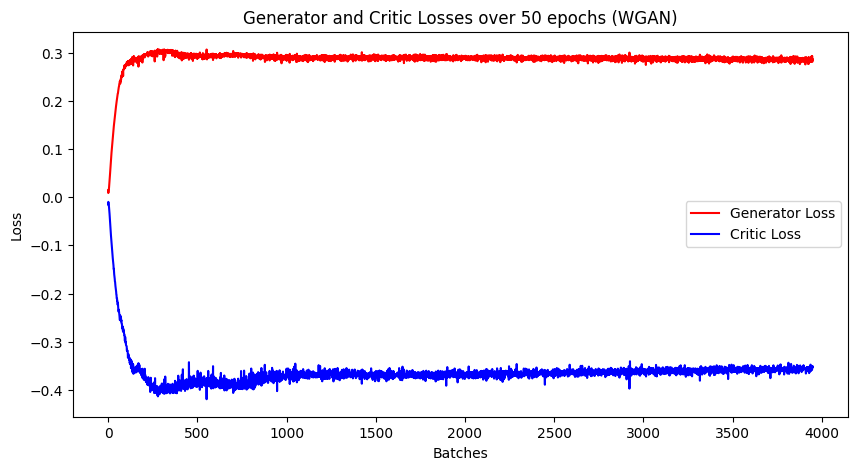

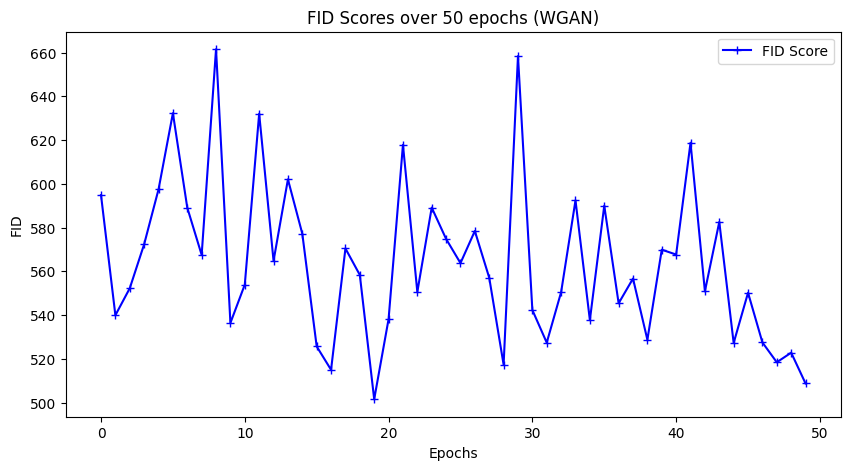

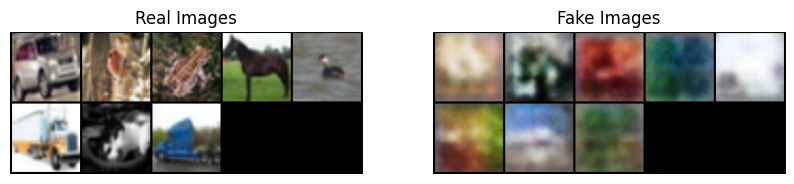

In [1]:
import os
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image
from torchvision.models import inception_v3, Inception_V3_Weights
from torch.utils.data import DataLoader, Subset
from torchvision.transforms.functional import resize
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
from PIL import Image
from tabulate import tabulate

# Suppress UserWarnings from torchvision
warnings.filterwarnings("ignore", category=UserWarning, module="torchvision")

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained InceptionV3 model
weights = Inception_V3_Weights.IMAGENET1K_V1  # Explicitly specify weights
inception_model = inception_v3(weights=weights).to(device)
inception_model.fc = nn.Identity()  # Remove final classification layer
inception_model.eval()

# Hyperparameters
latent_vector_dim = 100
batch_size = 64
num_channels = 3
learning_rate = 5e-5
num_epochs = 50
subset_size = 5000  # Use a subset of the dataset
image_size = 64  # CIFAR-10 image size for training
critic_iterations = 5
weight_clipping_limit = 0.01

# Dataset preparation
data_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

cifar10_data = datasets.CIFAR10(root='./cifar10_data', train=True, download=True, transform=data_transform)
cifar10_subset = Subset(cifar10_data, list(range(subset_size)))  # Use a subset for faster training
data_loader = DataLoader(cifar10_subset, batch_size=batch_size, shuffle=True, num_workers=2)

# Generator network
class ImageGenerator(nn.Module):
    def __init__(self, latent_dim, num_channels):
        super(ImageGenerator, self).__init__()
        self.generator_net = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, num_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.generator_net(x)


# Critic network
class ImageCritic(nn.Module):
    def __init__(self, num_channels):
        super(ImageCritic, self).__init__()
        self.critic_net = nn.Sequential(
            nn.Conv2d(num_channels, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0, bias=False)
        )

    def forward(self, x):
        return self.critic_net(x).view(-1)


# Initialize WGAN networks
gen_model = ImageGenerator(latent_vector_dim, num_channels).to(device)
critic_model = ImageCritic(num_channels).to(device)

# Optimizers
optimizer_gen = optim.RMSprop(gen_model.parameters(), lr=learning_rate)
optimizer_critic = optim.RMSprop(critic_model.parameters(), lr=learning_rate)

def extract_features(images, model):
    # Resize images to match the InceptionV3 input size 
    images_resized = torch.nn.functional.interpolate(images, size=(256, 256), mode='bilinear', align_corners=False)
    
    # Normalize the images using InceptionV3's expected normalization
    transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    images_normalized = transform(images_resized)
    
    # Extract features from the InceptionV3 model (without the final classification layer)
    with torch.no_grad():
        features = model(images_normalized)  # Extract features from the penultimate layer
    return features



def calculate_fid(real_features, fake_features):
    # Convert the features from PyTorch tensors to NumPy arrays
    real_features = real_features.cpu().numpy()  # Convert to NumPy array
    fake_features = fake_features.cpu().numpy()  # Convert to NumPy array

    # Compute mean and covariance for real and fake features
    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_features, axis=0), np.cov(fake_features, rowvar=False)

    # Calculate the FID score
    diff = np.sum((mu_real - mu_fake) ** 2)
    cov_mean = sqrtm(sigma_real @ sigma_fake)
    if np.iscomplexobj(cov_mean):
        cov_mean = cov_mean.real
    return diff + np.trace(sigma_real + sigma_fake - 2 * cov_mean)



# Helper function to save resized grids
# Helper function to save resized grids
def save_grids(real_images, fake_images, epoch, output_dir, resize_dims=(64, 64)):

    # Resize fake images to match real images
    fake_images_resized = torch.nn.functional.interpolate(fake_images, size=resize_dims, mode='bilinear', align_corners=False)

    # Create grids with consistent layout
    num_images = min(len(real_images), len(fake_images_resized))
    real_grid = make_grid(real_images[:num_images], nrow=5, normalize=True)
    fake_grid = make_grid(fake_images_resized[:num_images], nrow=5, normalize=True)

    # Save the grids
    save_image(real_grid, os.path.join(output_dir, f"real_grid_epoch_{epoch}.png"))
    save_image(fake_grid, os.path.join(output_dir, f"fake_grid_epoch_{epoch}.png"))


# Create output directory
outputs_wgan_dir = "./outputs_wgan"
os.makedirs(outputs_wgan_dir, exist_ok=True)



# Training process
gen_losses, critic_losses, fid_scores = [], [], []
results = []
fixed_noise = torch.randn(32, latent_vector_dim, 1, 1, device=device)

print("Training process for WGAN:")
for epoch in range(num_epochs):
    for batch_idx, (real_imgs, _) in enumerate(data_loader):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Train critic
        for _ in range(critic_iterations):
            critic_model.zero_grad()
            noise = torch.randn(batch_size, latent_vector_dim, 1, 1, device=device)
            fake_imgs = gen_model(noise)
            critic_real = critic_model(real_imgs).mean()
            critic_fake = critic_model(fake_imgs.detach()).mean()
            critic_loss = -(critic_real - critic_fake)
            critic_loss.backward()
            optimizer_critic.step()

            # Weight clipping for Lipschitz constraint
            for p in critic_model.parameters():
                p.data.clamp_(-weight_clipping_limit, weight_clipping_limit)

        # Train generator
        gen_model.zero_grad()
        fake_imgs = gen_model(noise)
        gen_loss = -critic_model(fake_imgs).mean()
        gen_loss.backward()
        optimizer_gen.step()

        # Record losses
        gen_losses.append(gen_loss.item())
        critic_losses.append(critic_loss.item())

    # Calculate FID score
    real_features = extract_features(real_imgs, inception_model)
    fake_features = extract_features(fake_imgs, inception_model)
    fid_score = calculate_fid(real_features, fake_features)
    fid_scores.append(fid_score)

    # Save grids of real and fake images
    save_grids(real_imgs, fake_imgs, epoch + 1, outputs_wgan_dir)  # Corrected line

    # Append results for the current epoch to the table
    results.append([epoch + 1, f"{gen_losses[-1]:.4f}", f"{critic_losses[-1]:.4f}", f"{fid_score:.4f}"])

# Final table printed at the end of training
print(tabulate(results, headers=["Epoch", "Generator Loss", "Critic Loss", "FID Score"], tablefmt="fancy_grid"))

# Save the table to a file
table_file_path = os.path.join(outputs_wgan_dir, "training_results.txt")
with open(table_file_path, "w") as file:
    file.write(tabulate(results, headers=["Epoch", "Generator Loss", "Critic Loss", "FID Score"], tablefmt="fancy_grid"))

print(f"Training results saved to {table_file_path}")


# Plot losses
plt.figure(figsize=(10, 5))
plt.title("Generator and Critic Losses over 50 epochs (WGAN)")
plt.plot(gen_losses, label="Generator Loss",color="red")
plt.plot(critic_losses, label="Critic Loss",color="blue")
plt.xlabel("Batches")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.join(outputs_wgan_dir, "losses.png"))
plt.show()

# Plot FID scores
plt.figure(figsize=(10, 5))
plt.title("FID Scores over 50 epochs (WGAN)")
plt.plot(fid_scores, label="FID Score", marker='+',color="blue")
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.legend()
plt.savefig(os.path.join(outputs_wgan_dir, "fid_scores.png"))
plt.show()


# After the training loop and printing the table
# Display the saved grid for the last epoch 
last_epoch = num_epochs  
real_image_path = os.path.join(outputs_wgan_dir, f"real_grid_epoch_{last_epoch}.png")
fake_image_path = os.path.join(outputs_wgan_dir, f"fake_grid_epoch_{last_epoch}.png")

# Load the saved images using PIL
real_images = Image.open(real_image_path)
fake_images = Image.open(fake_image_path)

# Plot the real and fake images side by side
plt.figure(figsize=(10, 5))

# Plot real images
plt.subplot(1, 2, 1)
plt.imshow(real_images)
plt.title("Real Images")
plt.axis('off')

# Plot fake images
plt.subplot(1, 2, 2)
plt.imshow(fake_images)
plt.title("Fake Images")
plt.axis('off')

plt.show()

In [2]:
!zip -r outputs_wgan.zip outputs_wgan

  adding: outputs_wgan/ (stored 0%)
  adding: outputs_wgan/.ipynb_checkpoints/ (stored 0%)
  adding: outputs_wgan/.ipynb_checkpoints/fake_grid_epoch_1-checkpoint.png (deflated 0%)
  adding: outputs_wgan/.ipynb_checkpoints/fake_grid_epoch_11-checkpoint.png (deflated 0%)
  adding: outputs_wgan/.ipynb_checkpoints/fake_grid_epoch_13-checkpoint.png (deflated 0%)
  adding: outputs_wgan/.ipynb_checkpoints/fake_grid_epoch_14-checkpoint.png (deflated 0%)
  adding: outputs_wgan/.ipynb_checkpoints/fake_grid_epoch_17-checkpoint.png (deflated 0%)
  adding: outputs_wgan/.ipynb_checkpoints/fake_grid_epoch_2-checkpoint.png (deflated 0%)
  adding: outputs_wgan/.ipynb_checkpoints/fake_grid_epoch_21-checkpoint.png (deflated 0%)
  adding: outputs_wgan/.ipynb_checkpoints/fake_grid_epoch_27-checkpoint.png (deflated 0%)
  adding: outputs_wgan/.ipynb_checkpoints/fake_grid_epoch_3-checkpoint.png (deflated 0%)
  adding: outputs_wgan/.ipynb_checkpoints/fake_grid_epoch_38-checkpoint.png (deflated 0%)
  adding: ou